# 11.1 Feature Engineering for Real Market Data
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:

Build a self-contained laboratory for feature engineering applied to financial time series.

We want to show how to transform raw market prices into explanatory variables that can later feed machine-learning models by :
- load and structure daily financial time series,
- compute simple and log-returns,
- build volatility, trend and momentum indicators,
- explore structural time features (drawdowns, autocorrelation),
- construct a prediction target with no look-ahead bias,
- run quick diagnostics and correlation analysis.

**This notebook**: 

is independent and focuses on core concepts that are useful for any downstream ML modelling in finance.


# 0. Setup & Data Loading

We work with daily prices for a small universe of liquid assets (ETFs and FX). Data can be obtained from online providers such as Yahoo Finance.
Some important points : daily frequency (business days, sometimes with holidays),  missing values or different calendars across assets must be aligned, time integrity is critical: all features for date t must be built using information available up to t, never from the future.

We will download 5 assets:
- SPY (S&P 500 ETF)
- QQQ (Nasdaq 100 ETF)
- TLT (US long bonds)
- GLD (Gold)
- EURUSD=X (EUR/USD FX)

We will use SPY as our main asset to build the feature set and the prediction target. The other series are mainly used for visual context.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

def get_price_data(ticker, start="2015-01-01", end=None):
    data = yf.download(ticker, start=start, end=end, progress=False)
    df = data[["Close"]].rename(columns={"Close": ticker})
    return df

tickers = ["SPY", "QQQ", "TLT", "GLD", "EURUSD=X"]
main_ticker = "SPY"

price_dfs = []
for t in tickers:
    df_t = get_price_data(t)
    price_dfs.append(df_t)

prices = pd.concat(price_dfs, axis=1)
prices = prices.sort_index().ffill().dropna()
prices.columns = [col if not isinstance(col, tuple) else col[-1] for col in prices.columns]

prices.head()

,SPY,QQQ,TLT,GLD,EURUSD=X
Date,,,,,
2015-01-02,171.093689,94.906548,95.129265,114.080002,1.208941
2015-01-05,168.003754,93.514397,96.623581,115.800003,1.194643
2015-01-06,166.421387,92.260521,98.364479,117.120003,1.193902
2015-01-07,168.495178,93.449852,98.170219,116.430000,1.187536
2015-01-08,171.485123,95.238472,96.870117,115.940002,1.183600


We first visualise the price dynamics of each asset.

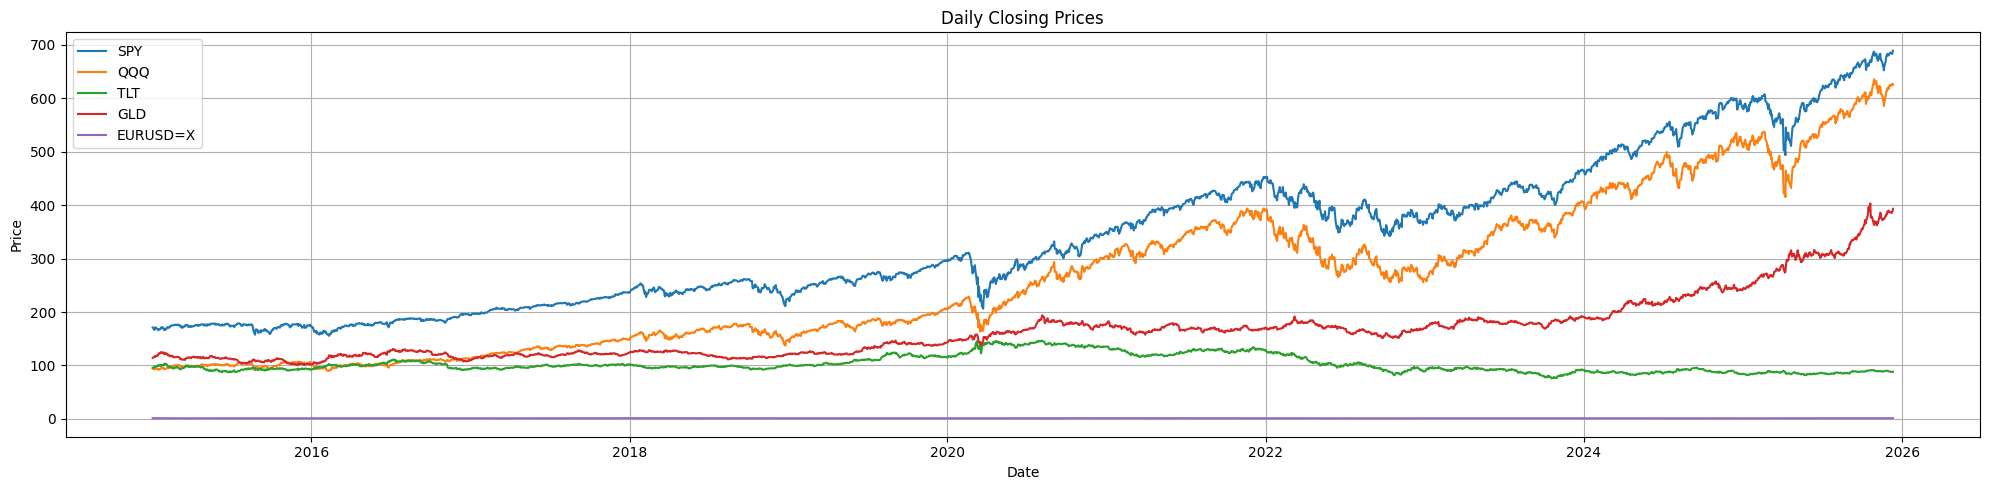

In [12]:
fig, ax = plt.subplots(figsize=(20, 5))
for t in tickers:
    ax.plot(prices.index, prices[t], label=t)
ax.set_title("Daily Closing Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
fig.tight_layout()
plt.show()

- Equities (SPY, QQQ) show a strong long-term upward drift with pronounced drawdowns; QQQ outperforms but with higher volatility.
- Bonds (TLT) shift from a slow upward trend pre-2020 to a persistent decline during the rate-hike cycle, reflecting pure interest-rate risk.
- Gold (GLD) behaves as a defensive asset: mostly stable with sharp upward bursts during macro uncertainty.
- EURUSD is essentially mean-reverting, oscillating in a narrow band with occasional medium-term trends driven by monetary-policy differentials.
- Crisis periods cause simultaneous volatility spikes across assets, reducing diversification and revealing common macro shocks.

We now build a working DataFrame for the main asset only.

In [13]:
df = pd.DataFrame(index=prices.index)
df["price"] = prices[main_ticker]
df.head(5)

,price
Date,
2015-01-02,171.093689
2015-01-05,168.003754
2015-01-06,166.421387
2015-01-07,168.495178
2015-01-08,171.485123


1. Returns & Basic Transformations

# 1. Returns & Basic Transformations

We start by transforming prices into returns. We distinguish:

**Simple return**

$$r_t = \frac{P_t}{P_{t-1}} - 1$$

**Log-return**

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$

Log-returns are additive over time, which makes them more convenient for modelling and aggregation.

We also introduce:

- lagged returns: $r_{t-1}, r_{t-5}, r_{t-20}$
- 20-day rolling z-score of returns as a simple normalisation.

In [14]:
# Simple and log returns
df["ret_simple"] = df["price"].pct_change()
df["ret_log"] = np.log(df["price"] / df["price"].shift(1))

# Lagged returns (1, 5, 20 days)
df["ret_log_lag1"] = df["ret_log"].shift(1)
df["ret_log_lag5"] = df["ret_log"].shift(5)
df["ret_log_lag20"] = df["ret_log"].shift(20)

# Rolling 20-day z-score of log returns
window_z = 20
rolling_mean = df["ret_log"].rolling(window_z).mean()
rolling_std = df["ret_log"].rolling(window_z).std()
df["ret_log_z20"] = (df["ret_log"] - rolling_mean) / rolling_std

df[["price", "ret_simple", "ret_log", "ret_log_lag1", "ret_log_z20"]].dropna().head()

,price,ret_simple,ret_log,ret_log_lag1,ret_log_z20
Date,,,,,
2015-01-30,166.113251,-0.012575,-0.012655,0.009201,-1.053782
2015-02-02,168.170380,0.012384,0.012308,-0.012655,1.194613
2015-02-03,170.602356,0.014461,0.014358,0.012308,1.251739
2015-02-04,169.952652,-0.003808,-0.003816,0.014358,-0.416510
2015-02-05,171.668381,0.010095,0.010045,-0.003816,1.035208


We inspect the distribution and time series of log-returns.

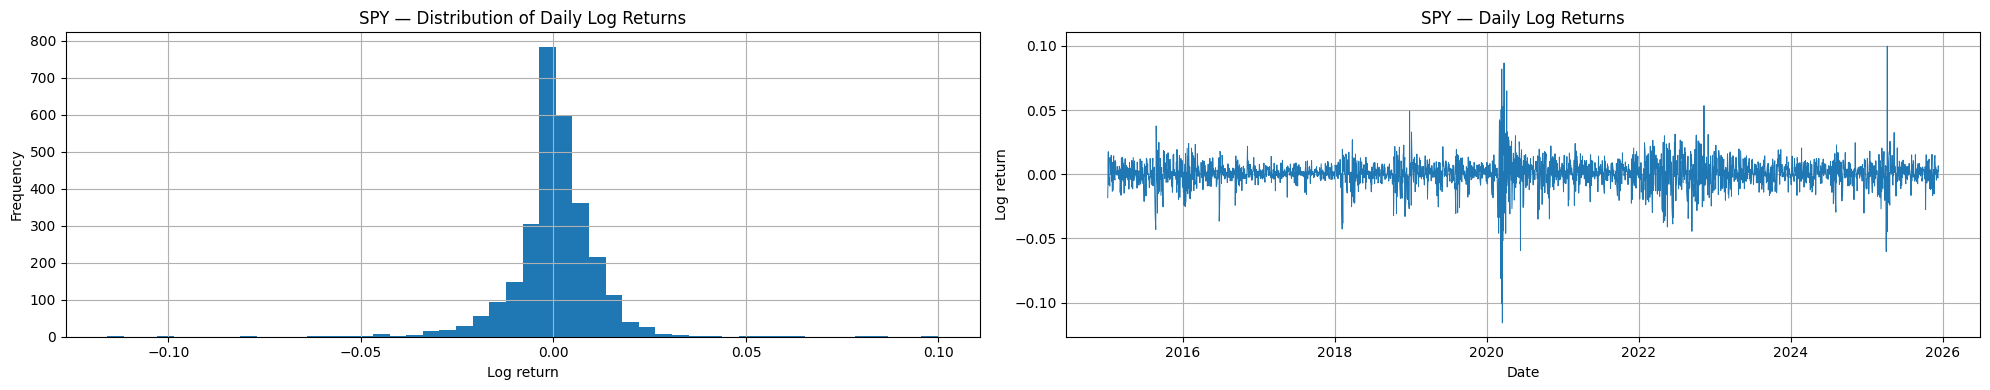

In [15]:
# Histogram and time series side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Histogram of log returns
df["ret_log"].dropna().hist(bins=50, ax=axes[0])
axes[0].set_title(f"{main_ticker} — Distribution of Daily Log Returns")
axes[0].set_xlabel("Log return")
axes[0].set_ylabel("Frequency")

# Time series of log returns
axes[1].plot(df.index, df["ret_log"], linewidth=0.7)
axes[1].set_title(f"{main_ticker} — Daily Log Returns")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Log return")

fig.tight_layout()
plt.show()

- The distribution is heavy-tailed (leptokurtic) compared to a Gaussian.
- Large moves occur rarely but contribute significantly to risk.
- Log-returns fluctuate around zero, with volatility clusters in crisis periods.

# 2. Volatility & Risk Features

Volatility is a key risk indicator. We estimate it using rolling windows of returns.

A simple rolling volatility estimator with window size $n$ is:

$$\sigma_t(n) = \sqrt{\frac{1}{n}\sum_{i=0}^{n-1}(r_{t-i} - \bar{r})^2}$$

We will compute:

- rolling volatility for windows 5, 10, 20, 60 days,
- the ratio of short-term volatility to long-term volatility,
- a simplified version of True Range (using close-to-close moves).


In [16]:
# Rolling volatility on log returns
for w in [5, 10, 20, 60]:
    df[f"vol_{w}"] = df["ret_log"].rolling(w).std()

# Volatility ratio: short-term vs long-term
df["vol_ratio_5_20"] = df["vol_5"] / df["vol_20"]
df["vol_ratio_10_60"] = df["vol_10"] / df["vol_60"]

# Simplified True Range: absolute daily log return
df["true_range_simplified"] = df["ret_log"].abs()

df[["vol_5", "vol_20", "vol_ratio_5_20", "true_range_simplified"]].dropna().head()

,vol_5,vol_20,vol_ratio_5_20,true_range_simplified
Date,,,,
2015-01-30,0.010537,0.010607,0.993425,0.012655
2015-02-02,0.013030,0.010261,1.269826,0.012308
2015-02-03,0.013673,0.010479,1.304767,0.014358
2015-02-04,0.011638,0.010195,1.141540,0.003816
2015-02-05,0.011740,0.009652,1.216368,0.010045


We overlay price and 20-day volatility.

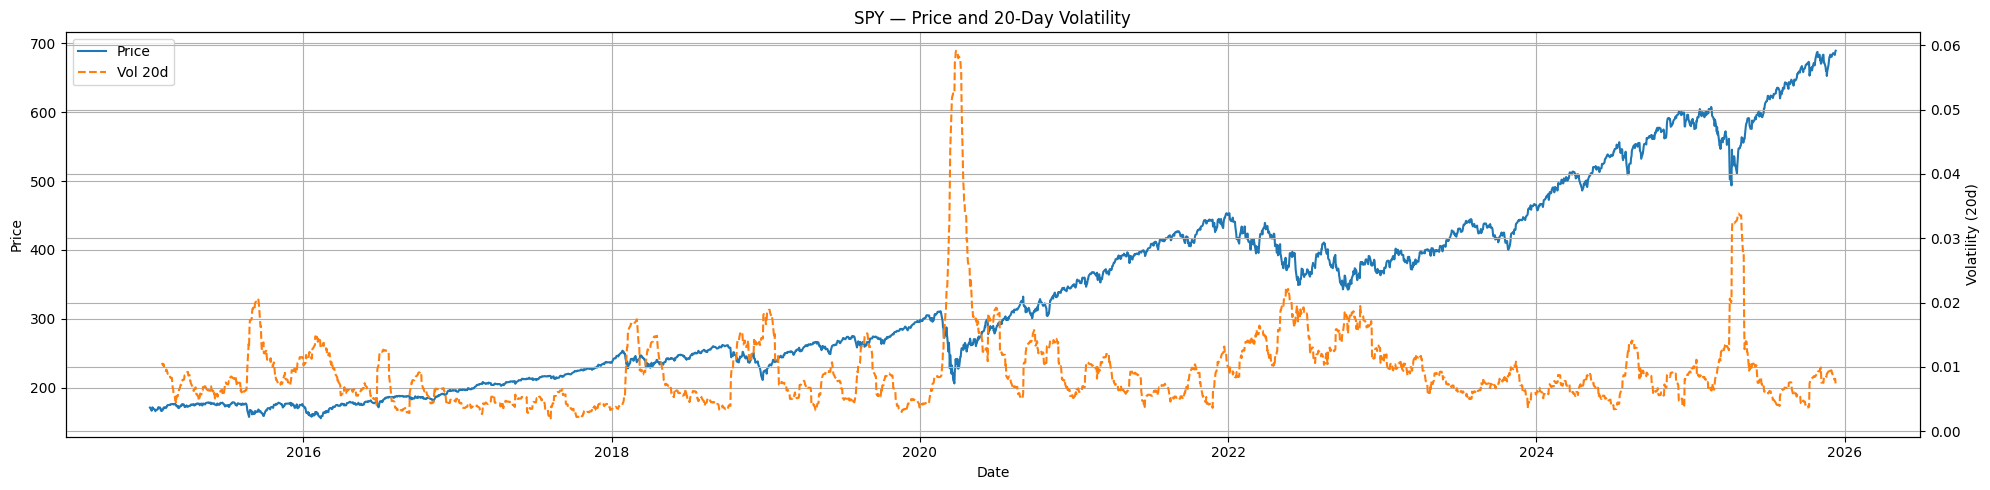

In [17]:
fig, ax1 = plt.subplots(figsize=(20, 5))

color_price = 'tab:blue'
ax1.plot(df.index, df["price"], label="Price", color=color_price)
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
color_vol = 'tab:orange'
ax2.plot(df.index, df["vol_20"], label="Vol 20d", linestyle="--", color=color_vol)
ax2.set_ylabel("Volatility (20d)")
ax2.tick_params(axis='y')

ax1.set_title(f"{main_ticker} — Price and 20-Day Volatility")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout()
plt.show()

We also visualise the volatility ratio.

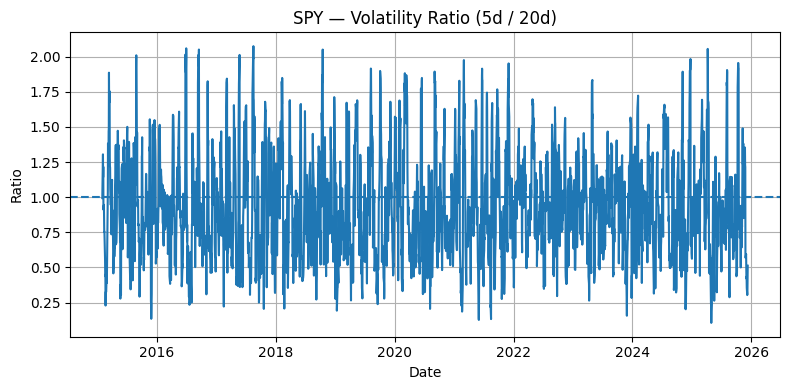

In [18]:
fig, ax = plt.subplots()
ax.plot(df.index, df["vol_ratio_5_20"], label="vol_5 / vol_20")
ax.axhline(1.0, linestyle="--")
ax.set_title(f"{main_ticker} — Volatility Ratio (5d / 20d)")
ax.set_xlabel("Date")
ax.set_ylabel("Ratio")
fig.tight_layout()
plt.show()

- Volatility spikes during periods of market stress.
- When short-term volatility is much higher than long-term volatility, the ratio peaks and often signals a regime change or a turbulent phase.

# 3. Trend & Momentum Indicators

Trend and momentum indicators try to exploit persistence in price movements.

We use:

**Simple Moving Average (SMA):**

$$\text{SMA}_t(n) = \frac{1}{n} \sum_{i=0}^{n-1} P_{t-i}$$

**Exponential Moving Average (EMA):**

$$\text{EMA}_t = \alpha P_t + (1-\alpha) \text{EMA}_{t-1}$$

**Relative Strength Index (RSI)** with 14 periods,

**MACD:**

$$\text{MACD} = \text{EMA}_{12} - \text{EMA}_{26}$$

plus a signal line (EMA of MACD).

We implement helper functions for RSI and MACD.


In [19]:
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist

# SMA and EMA
df["sma_20"] = df["price"].rolling(20).mean()
df["sma_50"] = df["price"].rolling(50).mean()
df["ema_20"] = df["price"].ewm(span=20, adjust=False).mean()

# RSI (14)
df["rsi_14"] = compute_rsi(df["price"], window=14)

# MACD
df["macd"], df["macd_signal"], df["macd_hist"] = compute_macd(df["price"])

We visualise SMA and EMA on top of price.

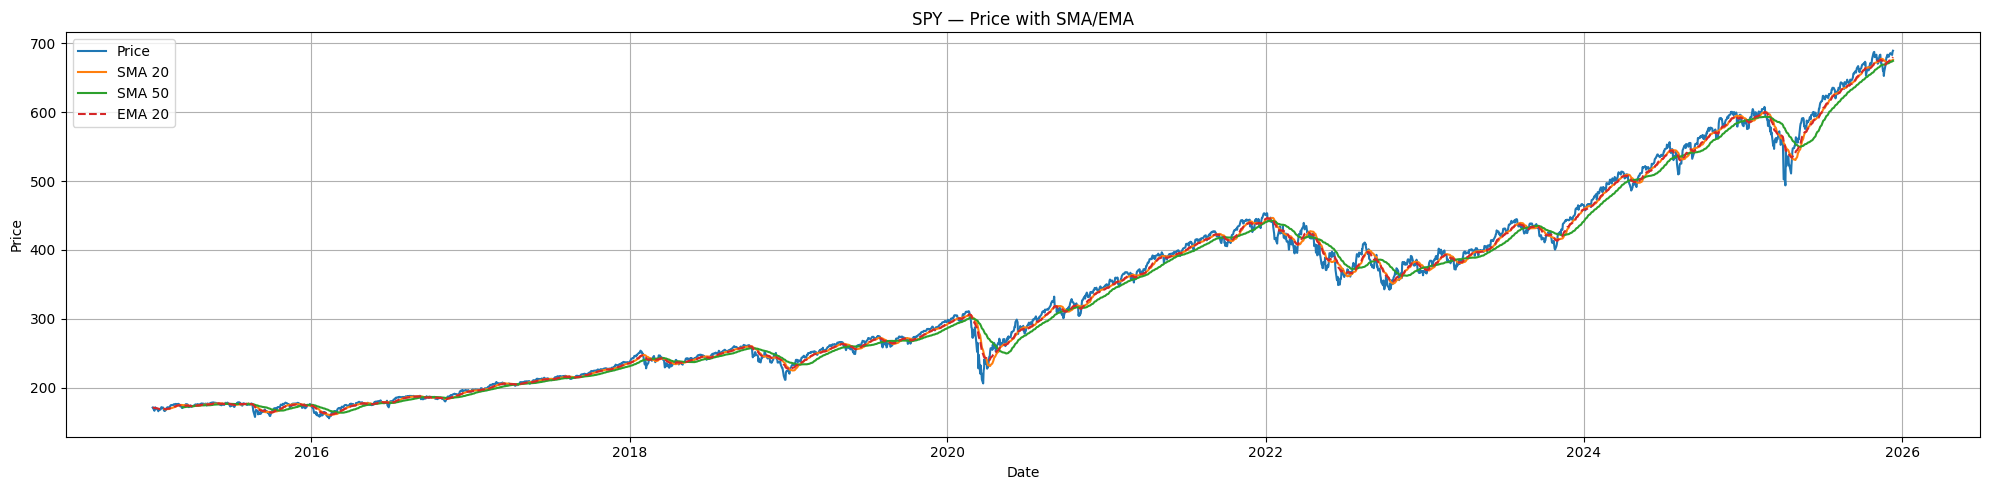

In [20]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df.index, df["price"], label="Price")
ax.plot(df.index, df["sma_20"], label="SMA 20")
ax.plot(df.index, df["sma_50"], label="SMA 50")
ax.plot(df.index, df["ema_20"], label="EMA 20", linestyle="--")
ax.set_title(f"{main_ticker} — Price with SMA/EMA")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
fig.tight_layout()
plt.show()

We plot RSI(14).

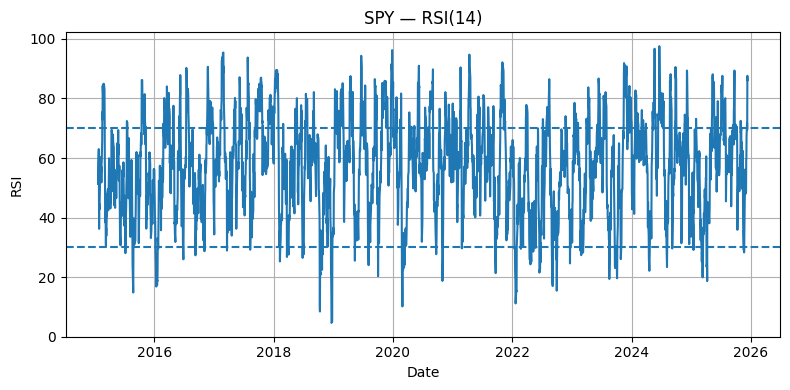

In [21]:
fig, ax = plt.subplots()
ax.plot(df.index, df["rsi_14"])
ax.axhline(70, linestyle="--")
ax.axhline(30, linestyle="--")
ax.set_title(f"{main_ticker} — RSI(14)")
ax.set_xlabel("Date")
ax.set_ylabel("RSI")
fig.tight_layout()
plt.show()

We plot MACD and its histogram.

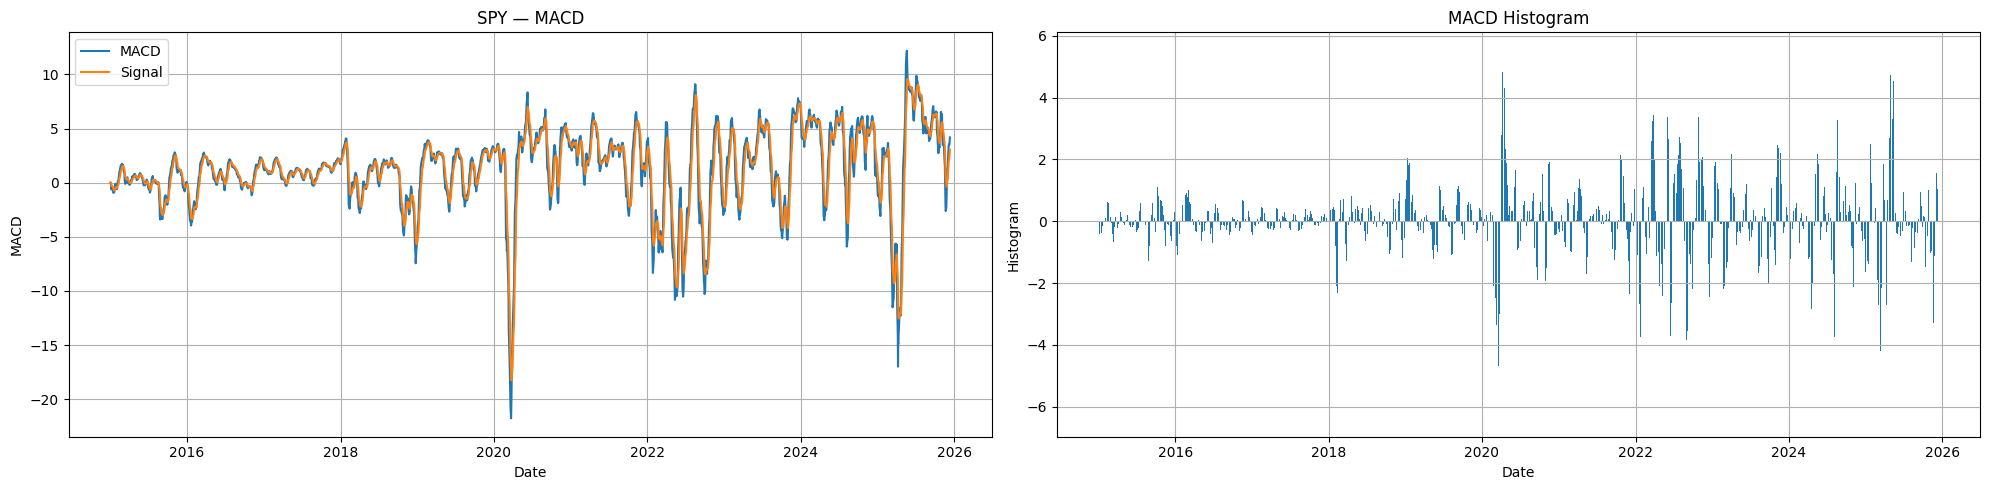

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(df.index, df["macd"], label="MACD")
ax1.plot(df.index, df["macd_signal"], label="Signal")
ax1.set_title(f"{main_ticker} — MACD")
ax1.set_xlabel("Date")
ax1.set_ylabel("MACD")
ax1.legend()

ax2.bar(df.index, df["macd_hist"], width=1.0)
ax2.set_title("MACD Histogram")
ax2.set_xlabel("Date")
ax2.set_ylabel("Histogram")

fig.tight_layout()
plt.show()

MACD–Signal crossovers align with shifts in momentum: MACD crossing above the signal typically marks improving trend strength, while downward crossovers flag momentum deterioration.
MACD above zero generally corresponds to bullish medium-term trend conditions; MACD below zero reflects bearish pressure.

Large negative MACD spikes (e.g., early 2020, 2022) coincide with sharp equity selloffs, signalling abrupt momentum collapse.

The histogram expands when momentum accelerates (positive or negative) and contracts when price movement stabilizes — visible as volatility compression outside crisis phases.
Sustained positive histogram bars indicate persistent upward momentum; sustained negatives point to prolonged weakness even before price visibly reverses.

# 4. Structural Time Features

We now construct features that describe the market state in a more structural way:

**Drawdown:** the distance between the current price and its past maximum.

**Rolling autocorrelation:** the degree of linear dependence between today's return and yesterday's return.

We define drawdown as:

$$\text{DD}_t = \frac{P_t}{\max_{0 \leq i \leq k} P_{t-i}} - 1,$$

where the rolling maximum is computed over a long horizon (e.g. 252 days ≈ 1 year of trading days).


In [23]:
# Rolling max over 1 year (approx 252 trading days)
roll_max = df["price"].rolling(252, min_periods=1).max()
df["drawdown"] = df["price"] / roll_max - 1.0

df[["price", "drawdown"]].tail()

,price,drawdown
Date,,
2025-12-05,685.690002,-0.002473
2025-12-08,683.630005,-0.005470
2025-12-09,683.039978,-0.006328
2025-12-10,687.570007,0.000000
2025-12-11,689.169983,0.000000


We plot the drawdown curve.

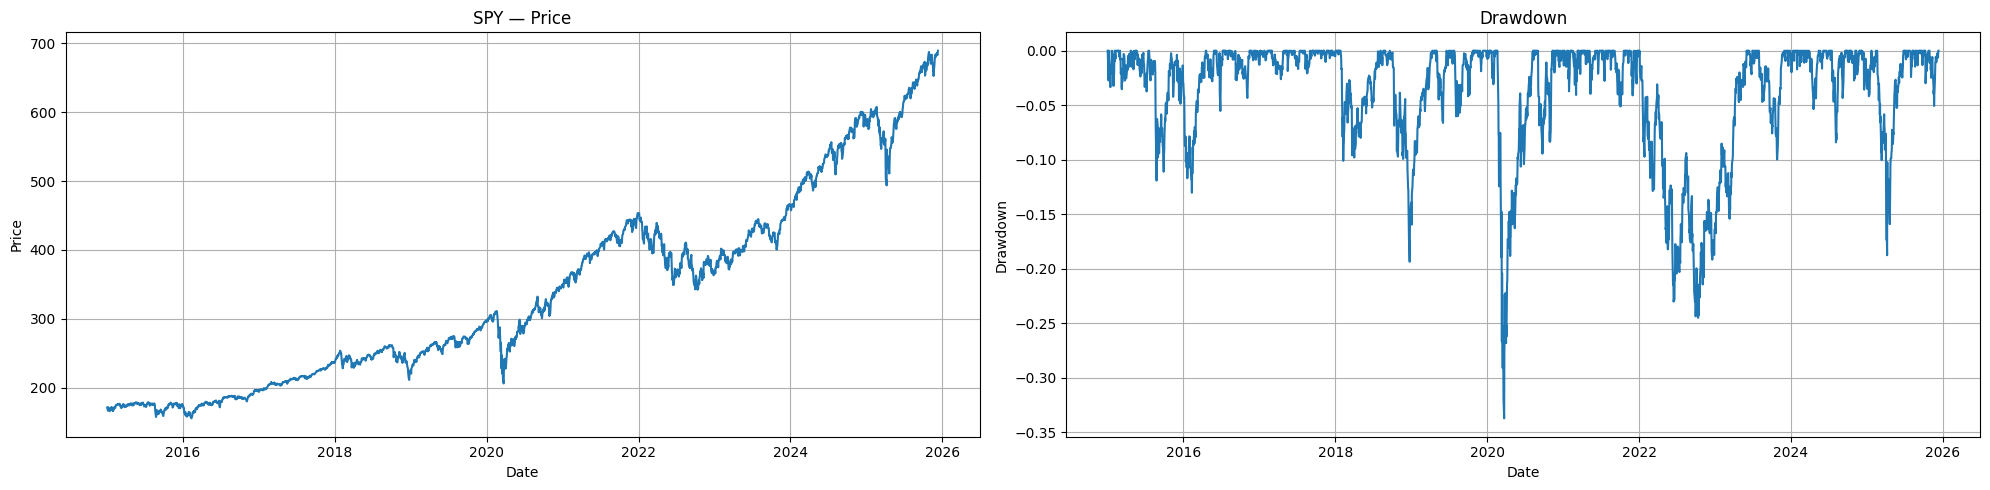

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(df.index, df["price"])
ax1.set_title(f"{main_ticker} — Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")

ax2.plot(df.index, df["drawdown"])
ax2.set_title("Drawdown")
ax2.set_xlabel("Date")
ax2.set_ylabel("Drawdown")

fig.tight_layout()
plt.show()

- SPY shows a strong long-term uptrend, but the drawdown chart reveals that this growth is punctuated by repeated pullbacks.
- Most drawdowns are shallow and short-lived, reflecting normal equity volatility.
- The major troughs (2020, 2022) stand out with deep, fast drawdowns that match severe market stress.
- Prolonged drawdown phases (e.g., 2022–2023) signal slow recoveries where price struggles to reclaim new highs.

Next, we compute rolling autocorrelation of daily log-returns at lag 1, using a sliding window (e.g. 60 days).

In [25]:
window_ac = 60

def rolling_autocorr(x):
    return x.autocorr(lag=1)

df["ret_log_autocorr_1_60"] = (
    df["ret_log"]
    .rolling(window_ac)
    .apply(rolling_autocorr, raw=False)
)

df[["ret_log", "ret_log_autocorr_1_60"]].tail()

,ret_log,ret_log_autocorr_1_60
Date,,
2025-12-05,0.001898,-0.053835
2025-12-08,-0.003009,-0.052518
2025-12-09,-0.000863,-0.051986
2025-12-10,0.006610,-0.052253
2025-12-11,0.002324,-0.054236


We plot the rolling autocorrelation.

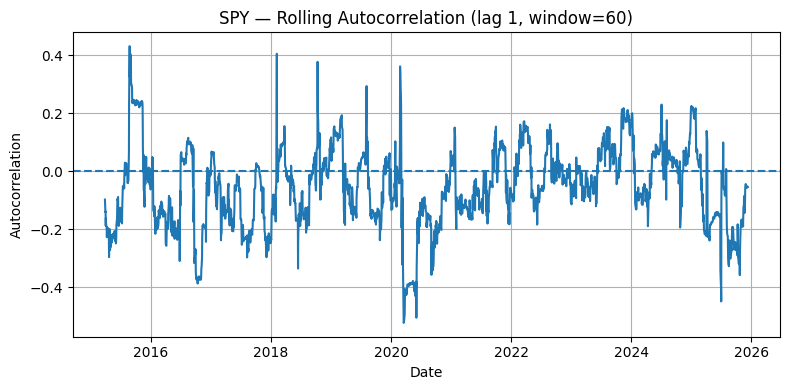

In [26]:
fig, ax = plt.subplots()
ax.plot(df.index, df["ret_log_autocorr_1_60"])
ax.axhline(0, linestyle="--")
ax.set_title(f"{main_ticker} — Rolling Autocorrelation (lag 1, window={window_ac})")
ax.set_xlabel("Date")
ax.set_ylabel("Autocorrelation")
fig.tight_layout()
plt.show()

- The rolling autocorrelation stays mostly near zero, consistent with daily equity returns behaving close to a random walk.
- Occasional positive spikes indicate short-lived trend reinforcement, typically during strong directional markets.
- Negative dips reflect brief mean-reversion phases, often after sharp moves or volatility shocks.
- The frequent oscillation around zero highlights that any predictability in SPY’s short-term returns is weak and unstable over time.

# 5. Target Construction (Prediction Goal)

We now define the prediction target.
To avoid look-ahead bias, we must ensure that the target at time t uses information strictly from time t+1 onward.

We define the target as the next-day log return:

$$y_t = r_{t+1}$$

We also build a binary version of the target based on the sign of the next-day return.


In [27]:
# Next-day log return as a regression target
df["y_next_ret_log"] = df["ret_log"].shift(-1)

# Binary version: +1 if next-day return > 0, -1 if < 0, 0 if exactly 0
df["y_next_sign"] = np.sign(df["y_next_ret_log"])

We inspect the distribution of the regression target.

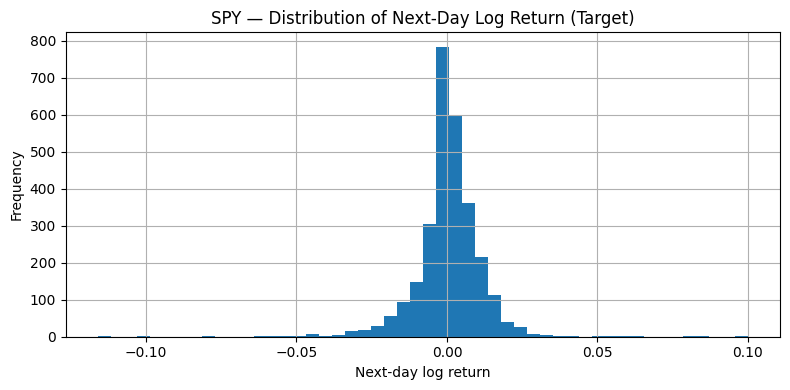

In [28]:
fig, ax = plt.subplots()
df["y_next_ret_log"].dropna().hist(bins=50, ax=ax)
ax.set_title(f"{main_ticker} — Distribution of Next-Day Log Return (Target)")
ax.set_xlabel("Next-day log return")
ax.set_ylabel("Frequency")
fig.tight_layout()
plt.show()

We also look at the class balance for the sign-based classification target.

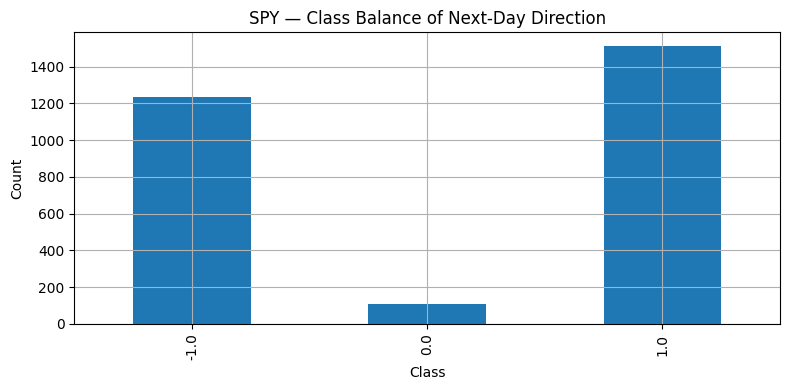

In [29]:
fig, ax = plt.subplots()
df["y_next_sign"].value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_title(f"{main_ticker} — Class Balance of Next-Day Direction")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
fig.tight_layout()
plt.show()

- The next-day return distribution is tightly centered around zero, with rare but sizable tail events typical of equity markets.
- The direction classes show a mild imbalance (slightly more +1 than –1), but nothing extreme enough to dominate model behaviour.
- Most next-day moves are tiny, making the prediction problem inherently low-signal and highly noisy.
- The rolling autocorrelation stays close to zero, confirming that short-term predictability is weak and unstable over time.

# 6. Quick Diagnostic & Correlation Analysis

Before fitting any model, we want a quick diagnostic of feature redundancy and linear relationships with the target.

We build a feature matrix X by selecting all engineered features, and then compute:

the full correlation matrix,

a barplot of absolute correlations with the regression target.

In [30]:
# List of feature columns (excluding price and direct returns)
feature_cols = [
    # returns & transformations
    "ret_log",
    "ret_log_lag1",
    "ret_log_lag5",
    "ret_log_lag20",
    "ret_log_z20",
    # volatility
    "vol_5",
    "vol_10",
    "vol_20",
    "vol_60",
    "vol_ratio_5_20",
    "vol_ratio_10_60",
    "true_range_simplified",
    # trend / momentum
    "sma_20",
    "sma_50",
    "ema_20",
    "rsi_14",
    "macd",
    "macd_signal",
    "macd_hist",
    # structural features
    "drawdown",
    "ret_log_autocorr_1_60",
]

target_col = "y_next_ret_log"

# Drop rows where either features or target are missing
dataset = df[feature_cols + [target_col]].dropna()

X = dataset[feature_cols]
y = dataset[target_col]

X.head()

,ret_log,ret_log_lag1,ret_log_lag5,ret_log_lag20,ret_log_z20,vol_5,vol_10,vol_20,vol_60,vol_ratio_5_20,...,true_range_simplified,sma_20,sma_50,ema_20,rsi_14,macd,macd_signal,macd_hist,drawdown,ret_log_autocorr_1_60
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-27,0.002287,-0.002384,0.008788,-0.003412,0.373412,0.006396,0.008748,0.008693,0.008653,0.735794,...,0.002287,173.656056,172.655002,173.523297,46.140542,-0.053570,0.228020,-0.281590,-0.025151,-0.097248
2015-03-30,0.012126,0.002287,-0.001950,0.006294,1.415236,0.009920,0.008566,0.009040,0.008448,1.097374,...,0.012126,173.539021,172.780757,173.589321,59.911480,0.014936,0.185403,-0.170467,-0.013258,-0.140380
2015-03-31,-0.008778,0.012126,-0.005635,-0.004113,-0.856962,0.010325,0.008997,0.009192,0.008435,1.123238,...,0.008778,173.382088,172.868897,173.504051,56.326940,-0.053020,0.137718,-0.190738,-0.021881,-0.138158
2015-04-01,-0.003543,-0.008778,-0.014762,-0.004225,-0.291520,0.007867,0.007925,0.009180,0.008308,0.856899,...,0.003543,173.231682,172.927833,173.368737,48.834276,-0.154376,0.079300,-0.233676,-0.025340,-0.187452
2015-04-02,0.003591,-0.003543,-0.002384,0.001094,0.469686,0.007879,0.008032,0.009225,0.008007,0.854047,...,0.003591,173.102652,172.948846,173.305276,53.802301,-0.182638,0.026912,-0.209550,-0.021834,-0.161331


We compute and plot the correlation matrix.

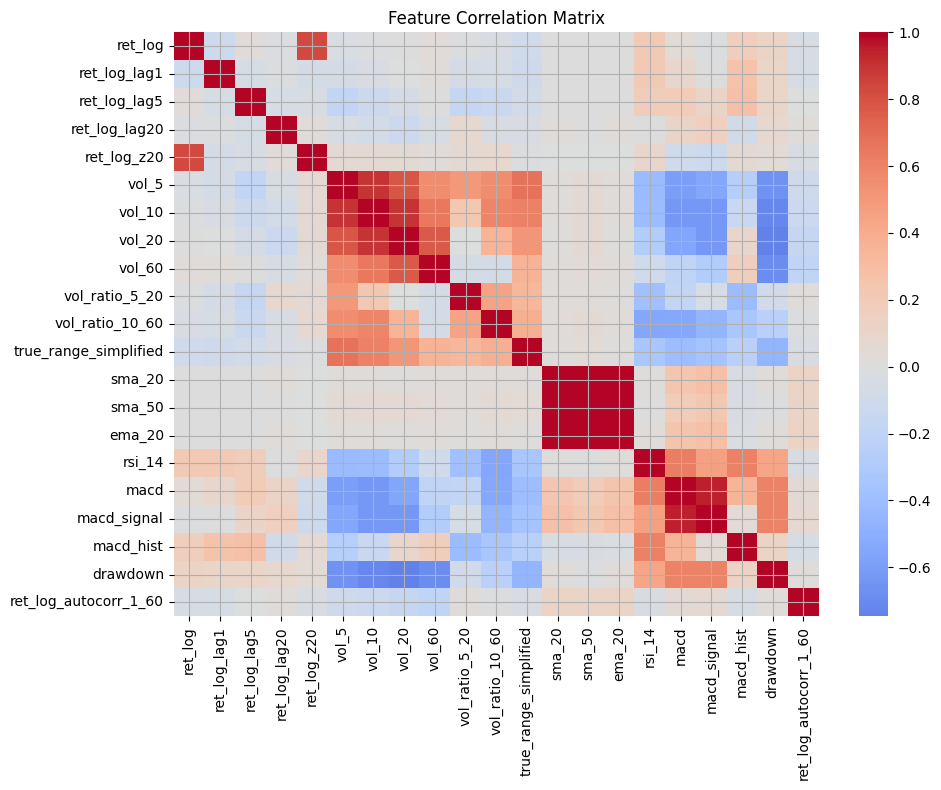

In [31]:
corr = X.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, ax=ax)
ax.set_title("Feature Correlation Matrix")
fig.tight_layout()
plt.show()

We also compute the correlation between each feature and the target.

In [32]:
corr_with_target = X.join(y).corr()[target_col].drop(target_col)
corr_with_target_abs = corr_with_target.abs().sort_values(ascending=False)

corr_with_target_abs.head(10)

ret_log                  0.115249
ret_log_lag5             0.085033
ret_log_lag1             0.067970
drawdown                 0.049063
vol_5                    0.041760
vol_60                   0.038934
ret_log_z20              0.033356
vol_ratio_5_20           0.031175
true_range_simplified    0.029117
rsi_14                   0.028912
Name: y_next_ret_log, dtype: float64

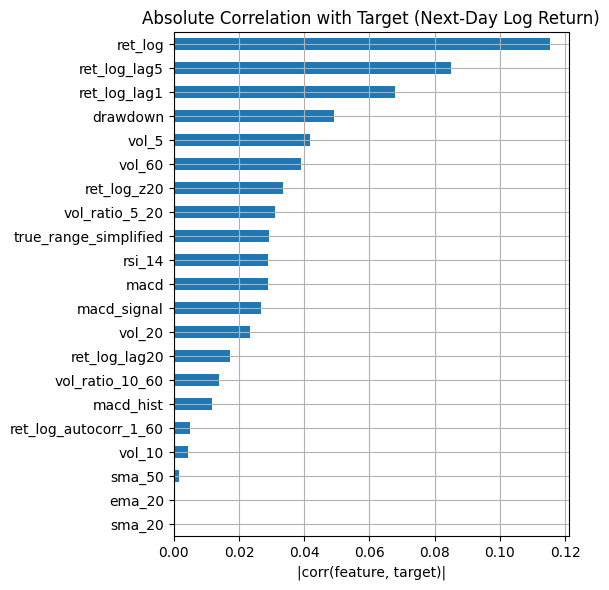

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
corr_with_target_abs.plot(kind="barh", ax=ax)
ax.invert_yaxis()
ax.set_title("Absolute Correlation with Target (Next-Day Log Return)")
ax.set_xlabel("|corr(feature, target)|")
fig.tight_layout()
plt.show()

- Many features cluster strongly together (e.g., moving averages, volatility windows), showing clear redundancy in the feature space.
- Correlations with the next-day return target remain very small, confirming how weakly informative most technical features are at a daily horizon.
- Past returns and short-term volatility carry the highest correlations, but even these signals are modest.
- This structure naturally calls for regularisation, dimensionality reduction, or non-linear models to avoid overfitting and extract whatever faint predictive signal exists.

# 7. Export of X and y

Finally, we export the feature matrix and the target for external model training.
We use the Parquet format for efficient storage.

In [34]:
Xy = dataset.copy()
Xy = Xy.reset_index().rename(columns={"index": "date"})
Xy.to_parquet("features_target_marketdata.parquet", index=False)
Xy.head()

,Date,ret_log,ret_log_lag1,ret_log_lag5,ret_log_lag20,ret_log_z20,vol_5,vol_10,vol_20,vol_60,...,sma_20,sma_50,ema_20,rsi_14,macd,macd_signal,macd_hist,drawdown,ret_log_autocorr_1_60,y_next_ret_log
0,2015-03-27,0.002287,-0.002384,0.008788,-0.003412,0.373412,0.006396,0.008748,0.008693,0.008653,...,173.656056,172.655002,173.523297,46.140542,-0.053570,0.228020,-0.281590,-0.025151,-0.097248,0.012126
1,2015-03-30,0.012126,0.002287,-0.001950,0.006294,1.415236,0.009920,0.008566,0.009040,0.008448,...,173.539021,172.780757,173.589321,59.911480,0.014936,0.185403,-0.170467,-0.013258,-0.140380,-0.008778
2,2015-03-31,-0.008778,0.012126,-0.005635,-0.004113,-0.856962,0.010325,0.008997,0.009192,0.008435,...,173.382088,172.868897,173.504051,56.326940,-0.053020,0.137718,-0.190738,-0.021881,-0.138158,-0.003543
3,2015-04-01,-0.003543,-0.008778,-0.014762,-0.004225,-0.291520,0.007867,0.007925,0.009180,0.008308,...,173.231682,172.927833,173.368737,48.834276,-0.154376,0.079300,-0.233676,-0.025340,-0.187452,0.003591
4,2015-04-02,0.003591,-0.003543,-0.002384,0.001094,0.469686,0.007879,0.008032,0.009225,0.008007,...,173.102652,172.948846,173.305276,53.802301,-0.182638,0.026912,-0.209550,-0.021834,-0.161331,0.000000
